In [29]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from GNN import Data_processing, Edge_features, Edges, Graph, Draw_graph, GCN, GAT
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

## Đọc và xử lý dữ liệu huấn luyện

In [30]:
real_data = pd.read_csv("./dataset_main/users.csv")
fake_data = pd.read_csv("./dataset_main/fusers.csv")

raw_data = pd.concat([real_data, fake_data], ignore_index=True)
labels = LabelEncoder().fit_transform(raw_data['dataset'])

data = Data_processing(raw_data)
pd.concat([data, pd.Series(labels, name='dataset')], axis=1)

,id,name,screen_name,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,time_zone,location,geo_enabled,default_profile,default_profile_image,updated,dataset
0,3610511,573,1106,20370,5470,2385,145,52,5,29,1006,0.0,0.0,0.0,1,0
1,5656162,2251,1409,3131,506,381,9,40,1,29,1022,0.0,0.0,0.0,1,0
2,5682702,2767,2626,4024,264,87,323,16,1,29,551,0.0,0.0,0.0,1,0
3,6067292,2527,942,40586,640,622,1118,32,1,29,793,1.0,0.0,0.0,1,0
4,6015122,157,680,2016,62,64,13,0,5,29,1459,1.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2813,1391497074,2438,859,1,0,17,0,0,1,23,776,0.0,1.0,0.0,0,1
2814,1391544607,528,199,0,1,17,0,0,1,23,793,0.0,1.0,0.0,0,1
2815,1391622127,1714,582,2,0,15,0,0,1,23,1024,0.0,1.0,0.0,0,1
2816,1391832212,1095,414,2,0,16,0,0,1,23,793,0.0,1.0,0.0,0,1


## Xây dựng GNN

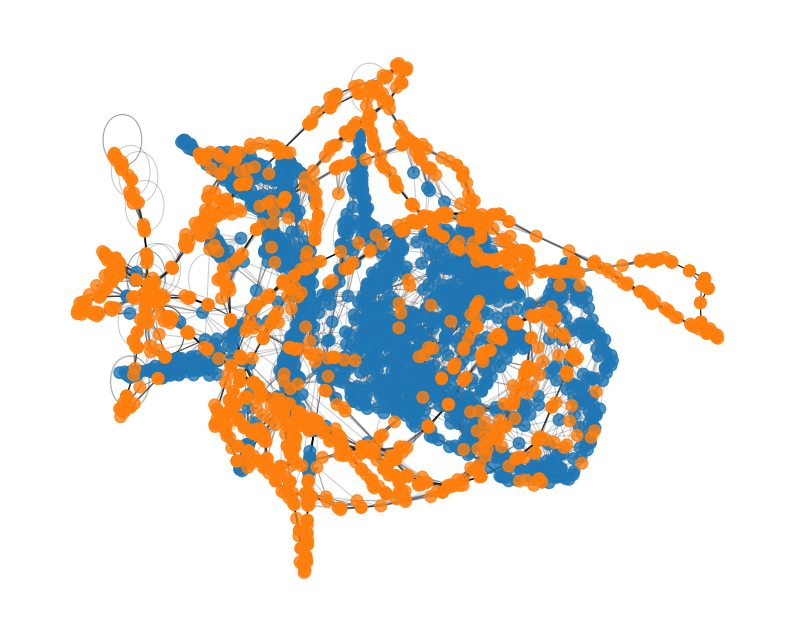

,statuses_count,followers_count,friends_count,favourites_count,listed_count,lang,time_zone
0,3.828534,0.635677,4.273168,-0.061941,2.094939,5.0,29.0
1,0.298702,0.016817,-0.030848,-0.156020,1.583784,1.0,29.0
2,0.481551,-0.013353,-0.662275,0.061192,0.561475,1.0,29.0
3,7.967931,0.033523,0.486751,0.611140,1.243014,1.0,29.0
4,0.070396,-0.038536,-0.711672,-0.153253,-0.120064,5.0,29.0
...,...,...,...,...,...,...,...
2813,-0.342192,-0.046265,-0.812615,-0.162246,-0.120064,1.0,23.0
2814,-0.342397,-0.046141,-0.812615,-0.162246,-0.120064,1.0,23.0
2815,-0.341987,-0.046265,-0.816910,-0.162246,-0.120064,1.0,23.0
2816,-0.341987,-0.046265,-0.814763,-0.162246,-0.120064,1.0,23.0


In [31]:
edge_features = Edge_features(data)
edges = Edges(edge_features, k=10)
graph = Graph(data, edges, labels)

Draw_graph(edges, labels, graph.num_nodes)
pd.DataFrame(edge_features, columns=['statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count', 'lang', 'time_zone'])

## Chia dữ liệu huấn luyện

In [32]:
num_nodes = graph.num_nodes
train, test = train_test_split(
    range(num_nodes),
    test_size=0.3, 
    random_state=42,
    stratify=labels
)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_mask[train] = True
test_mask[test] = True

graph.train_mask = train_mask
graph.test_mask = test_mask

## Huấn luyện Model GCN

In [ ]:
model = GCN(graph.num_node_features, 64, len(np.unique(labels)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph.x, graph.edge_index)
    loss = F.cross_entropy(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    model.eval()
    with torch.no_grad():
        out = model(graph.x, graph.edge_index)
        pred = out[mask].argmax(dim=1)
        acc = pred.eq(graph.y[mask]).sum().item() / mask.sum().item()
    return acc

In [ ]:
for epoch in range(1, 101):
    loss = train()
    train_acc = test(graph.train_mask)
    test_acc = test(graph.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

## Lưu Model

In [ ]:
torch.save(model.state_dict(), 'model.pth')
print("Model đã được lưu vào 'model.pth'.")

## Huấn luyện Model GAT

In [33]:
modelGAT = GAT(graph.num_node_features, 32, len(np.unique(labels)))
optimizer = torch.optim.Adam(modelGAT.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    modelGAT.train()
    optimizer.zero_grad()
    out = modelGAT(graph.x, graph.edge_index)
    loss = F.cross_entropy(out[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test(mask):
    modelGAT.eval()
    with torch.no_grad():
        out = modelGAT(graph.x, graph.edge_index)
        pred = out[mask].argmax(dim=1)
        acc = pred.eq(graph.y[mask]).sum().item() / mask.sum().item()
    return acc

In [34]:
for epoch in range(1, 101):
    loss = train()
    train_acc = test(graph.train_mask)
    test_acc = test(graph.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Loss: 0.8357, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 002, Loss: 0.8886, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 003, Loss: 0.5101, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 004, Loss: 0.4566, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 005, Loss: 0.4118, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 006, Loss: 0.3721, Train Acc: 0.5553, Test Acc: 0.5532
Epoch: 007, Loss: 0.3850, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 008, Loss: 0.3689, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 009, Loss: 0.3712, Train Acc: 0.5254, Test Acc: 0.5260
Epoch: 010, Loss: 0.3717, Train Acc: 0.6582, Test Acc: 0.6442
Epoch: 011, Loss: 0.3476, Train Acc: 0.5872, Test Acc: 0.5827
Epoch: 012, Loss: 0.3613, Train Acc: 0.6242, Test Acc: 0.6194
Epoch: 013, Loss: 0.3575, Train Acc: 0.7028, Test Acc: 0.6891
Epoch: 014, Loss: 0.3703, Train Acc: 0.7667, Test Acc: 0.7388
Epoch: 015, Loss: 0.3447, Train Acc: 0.8555, Test Acc: 0.8227
Epoch: 016, Loss: 0.3412, Train Acc: 0.8925, Test Acc: 0.8546
Epoch: 0

In [35]:
torch.save(modelGAT.state_dict(), 'GAT.pth')
print("Model đã được lưu vào 'GAT.pth'.")

Model đã được lưu vào 'GAT.pth'.
